In [54]:
from osgeo import gdal
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from numba import jit
from scipy import ndimage

In [2]:
fa_file = r'D:\hydrological_modelling\HydroSHEDS\hyd_af_acc_30s\hyd_af_acc_30s_ext.tif'
Q_stations = r'D:\hydrological_modelling\grdc_africa\gauged_runoff.csv' 
Q_station = r'1159105_Q_Day.Cmd.txt'

In [3]:
df_stations = pd.read_csv(Q_stations, index_col=[0])
selected_station = df_stations[df_stations.stations == Q_station]

In [4]:
lat = selected_station.lats.iloc[0]
lon = selected_station.lons.iloc[0]

In [94]:
# open gdal file
ds = gdal.Open(fa_file)

# open coordinates
gt = ds.GetGeoTransform()
xmin = gt[0]
xmax = gt[0] + (gt[1] * ds.RasterXSize)
ymin = gt[3] + (gt[-1] * ds.RasterYSize)
ymax = gt[3]
te = [xmin, ymin, xmax, ymax]

# get x and y offsets of start point
x_offset = int(np.floor((lon - top_left_lon)/w_e_px_res))
y_offset = int(np.floor((lat - top_left_lat)/n_s_px_res))


In [95]:
import geopandas as gpd
basins_ext_loc = r'D:\hydrological_modelling\self\basins_ext.geojson'


In [96]:
gpd_ext = gpd.read_file(r'D:\hydrological_modelling\self\extent.geojson')
basins = gpd.read_file(r'D:\hydrological_modelling\grdc_africa\subregions.geojson')
basins_ext = gpd.clip(basins, gpd_ext)
basins_ext.to_file(basins_ext_loc, driver='GeoJSON')

In [97]:
basins_raster_tif = r'D:\hydrological_modelling\self\basins_raster.tif'

In [98]:
br_ds = gdal.Rasterize(basins_raster_tif,
                       basins_ext_loc,
                       xRes=gt[1],
                       yRes=gt[5],
                       outputBounds=te,
                       attribute='FID',
                       outputType=gdal.GDT_Byte,
                       creationOptions=['COMPRESS=LZW', 'TILED=YES'])

In [99]:
br_arr = br_ds.ReadAsArray()

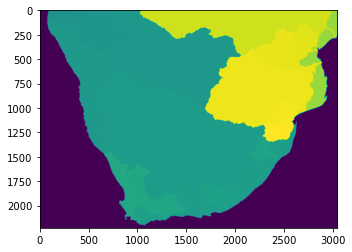

In [100]:
plt.imshow(br_arr)

In [101]:
# get offset of station on raster
top_left_lon, w_e_px_res, _, top_left_lat, _, n_s_px_res = br_ds.GetGeoTransform()
x_offset = int(np.floor((lon - top_left_lon)/w_e_px_res))
y_offset = int(np.floor((lat - top_left_lat)/n_s_px_res))

In [102]:
# get flow accumulation raster
flow_acc_arr = ds.ReadAsArray()

In [103]:
# get value of the basin the station is located in
basin_val = br_arr[y_offset, x_offset]

In [135]:
# make a raster with only the basin of this value
basin_arr = flow_acc_arr (br_arr==basin_val).astype(int)

# get the value of the flow accumulation of the station
flow_val = flow_acc_arr[y_offset, x_offset]

In [136]:
# make a raster with only upstream values of the station
subbasin = (basin_arr<=flow_val).astype(int)

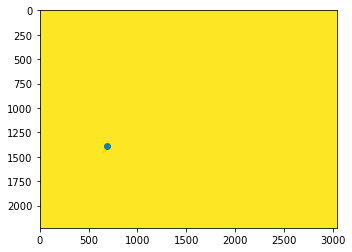

In [137]:
plt.imshow(subbasin)
plt.scatter(x_offset, y_offset)

In [21]:
condlist

[array([ True,  True,  True, False, False, False]),
 array([False, False, False, False,  True,  True])]

In [22]:
np.select

[array([0, 1, 2, 3, 4, 5]), array([ 0,  1,  4,  9, 16, 25], dtype=int32)]

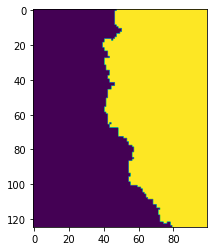

In [48]:
# open gdal file
fa_gd = gdal.Open(fa_file)

# open coordinates
top_left_lon, w_e_px_res, _, top_left_lat, _, n_s_px_res = fa_gd.GetGeoTransform()

# get x and y offsets of start point
x_offset = int(np.floor((lon - top_left_lon)/w_e_px_res))
y_offset = int(np.floor((lat - top_left_lat)/n_s_px_res))
x_start = x_offset
y_start = y_offset
# read flow accumulation as array
fa_arr = fa_gd.ReadAsArray()

# get starting data
fa_coords = np.array([[y_offset, x_offset]])

w_coords = np.array([(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)])
x_coords = np.zeros(fa_arr.shape[0] * fa_arr.shape[1], dtype=int)
y_coords = np.zeros_like(x_coords, dtype=int)
x_coords[0] = x_offset
y_coords[0] = y_offset
basin_arr = np.full(fa_arr.shape, False, dtype=bool)
basin_arr[x_offset, y_offset] = True

@jit(nopython=True)
def sub_basin_algo(x_offset, y_offset, fa_arr, w_coords, x_coords, y_coords, basin_arr):
    
    ic = 0
    jc = 0
    while True:

        y_offset = y_coords[ic]
        x_offset = x_coords[ic]

        # get value of coordinates
        fa_val = fa_arr[y_offset,x_offset]
        
        # iterate over window
        for i in range(-1,2,1):
            
            # make new coordinate
            y_offset_n = y_offset + i
            
            for j in range(-1,2,1):
                
                x_offset_n = x_offset + j

                # check if flow accumulation value of window is higher than original
                if not basin_arr[y_offset_n, x_offset_n]:
                    
                    fa_val_new = fa_arr[y_offset_n, x_offset_n]

                    if fa_val_new < fa_val:
                        jc += 1
                        basin_arr[y_offset_n, x_offset_n] = True
                        y_coords[jc] = y_offset_n
                        x_coords[jc] = x_offset_n

        # increment counter
        ic+=1
        if ic > jc:
            break
    return basin_arr, x_coords, y_coords

basin_arr, x_coords, y_coords = sub_basin_algo(x_offset, y_offset, fa_arr, w_coords, x_coords, y_coords, basin_arr)

plt.figure()
plt.imshow(basin_arr[1325:1450, 650:750])        


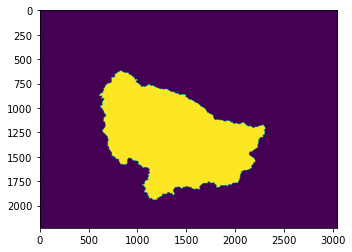

In [53]:
plt.imshow(ndimage.binary_fill_holes(basin_arr))

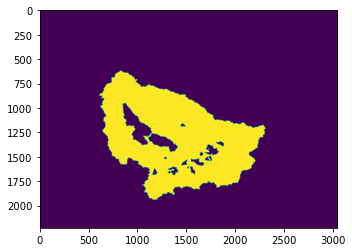

In [49]:
plt.imshow(basin_arr)

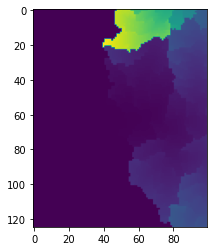

In [46]:
# open gdal file
fa_gd = gdal.Open(fa_file)

# open coordinates
top_left_lon, w_e_px_res, _, top_left_lat, _, n_s_px_res = fa_gd.GetGeoTransform()

# get x and y offsets of start point
x_offset = int(np.floor((lon - top_left_lon)/w_e_px_res))
y_offset = int(np.floor((lat - top_left_lat)/n_s_px_res))
x_start = x_offset
y_start = y_offset
# read flow accumulation as array
fa_arr = fa_gd.ReadAsArray()

# get starting data
fa_coords = np.array([[y_offset, x_offset]])

w_coords = np.array([(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)])
x_coords = np.zeros(fa_arr.shape[0] * fa_arr.shape[1], dtype=int)
y_coords = np.zeros_like(x_coords, dtype=int)
x_coords[0] = x_offset
y_coords[0] = y_offset
basin_arr = np.full(fa_arr.shape, 0, dtype=int)
basin_arr[x_offset, y_offset] = 0

@jit(nopython=True)
def sub_basin_algo(x_offset, y_offset, fa_arr, w_coords, x_coords, y_coords, basin_arr):
    
    ic = 0
    jc = 0
    while True:

        y_offset = y_coords[ic]
        x_offset = x_coords[ic]

        # get value of coordinates
        fa_val = fa_arr[y_offset,x_offset]
        
        # iterate over window
        for i in range(-1,2,1):
            
            # make new coordinate
            y_offset_n = y_offset + i
            
            for j in range(-1,2,1):
                
                x_offset_n = x_offset + j

                # check if flow accumulation value of window is higher than original
                if not basin_arr[y_offset_n, x_offset_n]:
                    
                    fa_val_new = fa_arr[y_offset_n, x_offset_n]

                    if fa_val_new < fa_val:
                        jc += 1
                        basin_arr[y_offset_n, x_offset_n] = jc
                        y_coords[jc] = y_offset_n
                        x_coords[jc] = x_offset_n

        # increment counter
        ic+=1
        if ic > jc:
            break
    return basin_arr, x_coords, y_coords

basin_arr, x_coords, y_coords = sub_basin_algo(x_offset, y_offset, fa_arr, w_coords, x_coords, y_coords, basin_arr)

plt.figure()
plt.imshow(basin_arr[1325:1450, 650:750])        


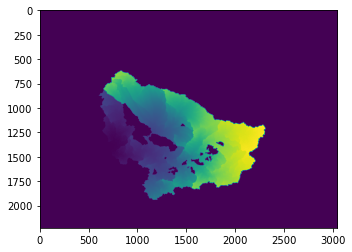

In [47]:
plt.imshow(basin_arr)

1159973

In [ ]:
# numy implementation

In [16]:
# open gdal file
fa_gd = gdal.Open(fa_file)

# open coordinates
top_left_lon, w_e_px_res, _, top_left_lat, _, n_s_px_res = fa_gd.GetGeoTransform()

# get x and y offsets of start point
x_offset = int(np.floor((lon - top_left_lon)/w_e_px_res))
y_offset = int(np.floor((lat - top_left_lat)/n_s_px_res))
x_start = x_offset
y_start = y_offset
# read flow accumulation as array
fa_arr = fa_gd.ReadAsArray()

# get starting data
fa_coords = np.array([[y_offset, x_offset]])
three = [-1,0,1]
window = np.array([(i, j) for i in three for j in three]).reshape(3,3,2)
basin_arr = np.full(fa_arr.shape, False, dtype=bool)


def sub_basin_algo(x_offset, y_offset, fa_arr, fa_coords, window, basin_arr):
    
    i = 0
    while True:

        # check if we have not exceeded the length of the array aka we are done
        if i >= len(fa_coords): # switch for fa_coords
            break

        y_offset = fa_coords[i][0]
        x_offset = fa_coords[i][1]

        # get value of coordinates
        fa_val = fa_arr[y_offset, x_offset]

        # build 3x3 window around that of accumulation and corresponding coordinates
        fa_window = fa_arr[y_offset-1:y_offset+2, x_offset-1:x_offset+2]
        basin_window = basin_arr[y_offset-1:y_offset+2, x_offset-1:x_offset+2]
        coord_window = np.array([y_offset,x_offset]) + window

        # make selection part window that has less cells above than the current value
        # also remove already selected parts
        selection = [fa_window <= fa_val][0] & np.invert(basin_window)
        selected_coords = coord_window[selection]
        
        # fill in True values in basin array
        basin_arr[y_offset-1:y_offset+2, x_offset-1:x_offset+2] = basin_arr[y_offset-1:y_offset+2, x_offset-1:x_offset+2] | selection

        # add coordinates to flow accumulation coordinate list
        fa_coords = np.append(fa_coords, selected_coords, axis=0)

        # increment counter
        i+=1
    
    return basin_arr, fa_coords
basin_arr, fa_coords = sub_basin_algo(x_offset, y_offset, fa_arr, fa_coords, window, basin_arr)

plt.figure()
plt.imshow(basin_arr[1325:1450, 650:750])        


KeyboardInterrupt: 

4